In [1]:
import pandas as pd
def read_json_to_dataframe(file_path):
    return pd.read_json(file_path)

# change file path to your own directory
set1_human = read_json_to_dataframe('/kaggle/input/sml-asmt1/set1_human.json')
set1_machine = read_json_to_dataframe('/kaggle/input/sml-asmt1/set1_machine.json')
set2_human = read_json_to_dataframe('/kaggle/input/sml-asmt1/set2_human.json')
set2_machine = read_json_to_dataframe('/kaggle/input/sml-asmt1/set2_machine.json')
predict_x = read_json_to_dataframe('/kaggle/input/sml-asmt1/test.json')

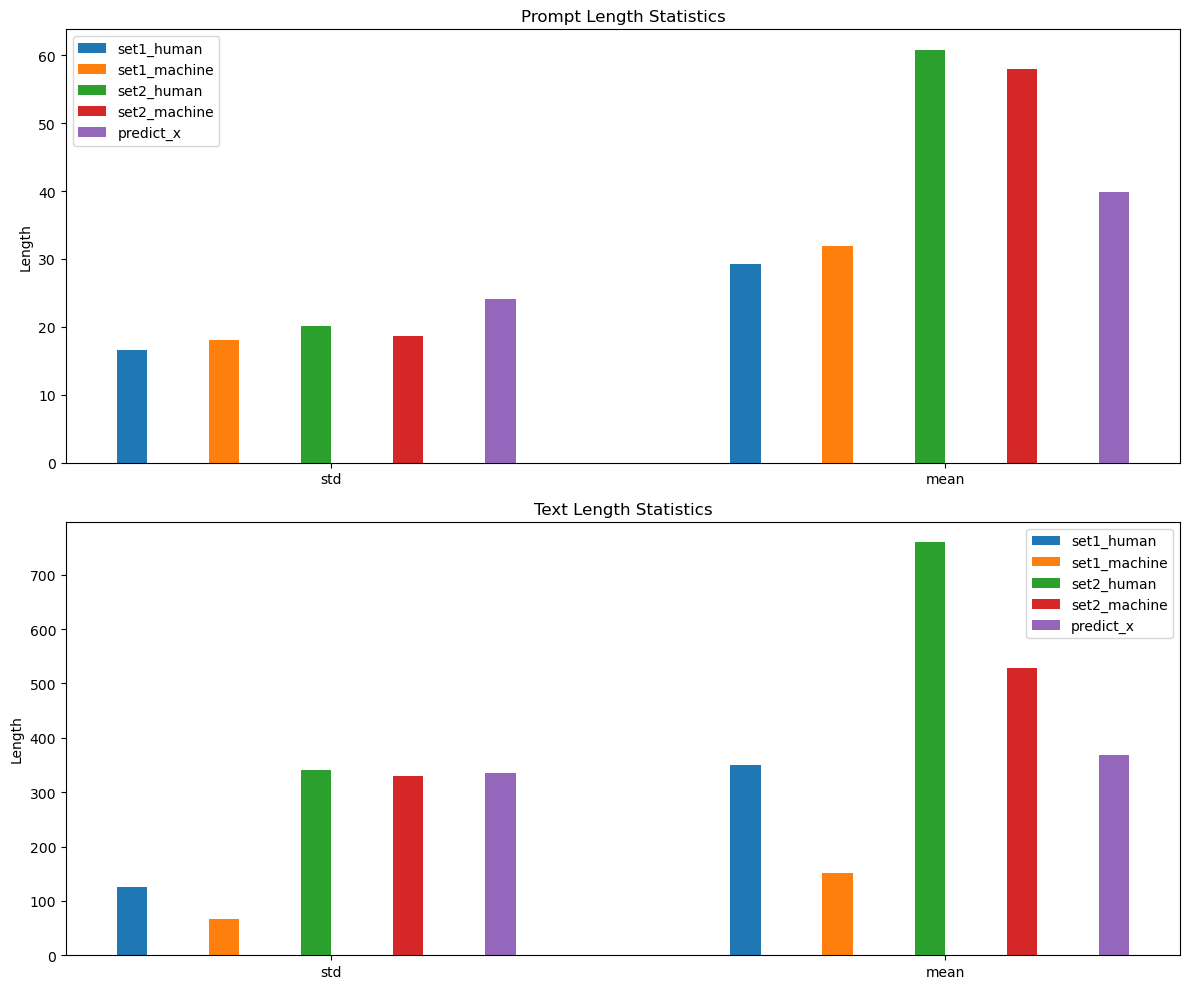

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# EDA

def create_bar_chart(title, ylabel, data_labels, data_values, ax):
    bar_width = 0.05
    group_spacing = 0.1
    num_datasets = len(data_labels)
    num_stats = len(next(iter(data_values.values())))
    x = np.arange(num_stats)

    for idx, (label, values) in enumerate(data_values.items()):
        ax.bar(x + idx * bar_width + (group_spacing * idx), values, width=bar_width, label=label)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x + (bar_width * num_datasets + group_spacing * (num_datasets - 1)) / 2)
    ax.set_xticklabels(['std', 'mean'])
    ax.legend()

datasets = [('set1_human', set1_human), ('set1_machine', set1_machine),
            ('set2_human', set2_human), ('set2_machine', set2_machine),
            ('predict_x', predict_x)]

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

prompt_stats = {}
text_stats = {}

for name, data in datasets:
    prompt_lengths = data['prompt'].apply(len)
    txt_lengths = data['txt'].apply(len)
    
    prompt_stats[name] = [ prompt_lengths.std(), prompt_lengths.mean()]
    text_stats[name] = [ txt_lengths.std(), txt_lengths.mean()]

create_bar_chart('Prompt Length Statistics', 'Length', datasets, prompt_stats, axes[0])
create_bar_chart('Text Length Statistics', 'Length', datasets, text_stats, axes[1])

plt.tight_layout()
plt.show()

In [3]:
# bag of words
import numpy as np
from scipy.sparse import lil_matrix

def integer_sequences_to_sparse_matrix(prompt_data, txt_data):
    num_samples = len(prompt_data)
    sparse_matrix = lil_matrix((num_samples, 10001), dtype=np.int8)
    
    for i, (prompt, txt) in enumerate(zip(prompt_data, txt_data)):
        sequence = prompt + [1] + txt
        prompt = True
        for token in sequence:
            if token == 1:
                prompt = False
            if prompt:
                sparse_matrix[i, token] += 1
            else:
                sparse_matrix[i, 5001 + token] += 1
        sparse_matrix[i,5001] = 0
        sparse_matrix[i,0] = 0   
    return sparse_matrix

# Apply the function to your datasets
set1_human_sparse = integer_sequences_to_sparse_matrix(set1_human['prompt'], set1_human['txt'])
set1_machine_sparse = integer_sequences_to_sparse_matrix(set1_machine['prompt'], set1_machine['txt'])
set2_human_sparse = integer_sequences_to_sparse_matrix(set2_human['prompt'], set2_human['txt'])
set2_machine_sparse = integer_sequences_to_sparse_matrix(set2_machine['prompt'], set2_machine['txt'])
predict_x_sparse = integer_sequences_to_sparse_matrix(predict_x['prompt'], predict_x['txt'])

In [4]:
from scipy.sparse import vstack
import numpy as np

# Combine the source datasets and create labels
source_X = vstack([set1_human_sparse, set1_machine_sparse])
source_y = np.hstack([np.ones(set1_human_sparse.shape[0]), np.zeros(set1_machine_sparse.shape[0])])
source_X = source_X.toarray()

In [5]:
# Combine the target datasets and create labels
target_X = vstack([set2_human_sparse, set2_machine_sparse])
target_y = np.hstack([np.ones(set2_human_sparse.shape[0]), np.zeros(set2_machine_sparse.shape[0])])
target_X= target_X.toarray()

In [6]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
# Initialize StratifiedKFold with 5 fole cross validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

In [12]:
# Perform cross-validation
from sklearn.metrics import confusion_matrix,f1_score
accuracies = []
model_list = []
f1_score_list_0 = []
f1_score_list_1 = []
accuracy_0_list = []
accuracy_1_list = []
for train_index, val_index in skf.split(source_X, source_y):
    X_train, X_val = source_X[train_index], source_X[val_index]
    y_train, y_val = source_y[train_index], source_y[val_index]
    # Train the LightGBM classifier on the training set
    lgb_train = lgb.Dataset(X_train, y_train)
    params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'reg_alpha' : 10,
    'n_jobs' : -1,    
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose':-1,
    'boosting': 'goss',
    'bagging_freq': 50,
    'pos_bagging_fraction': 0.0287,
    'neg_bagging_fraction': 1
    }

    gbm_initial = lgb.train(params,
                    lgb_train,
                    num_boost_round=100)
    
    gbm_initial.save_model('initial_model.txt')
    
    # fine tuned the model on target dataset
    lgb_target_train = lgb.Dataset(target_X, target_y)
    params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type':'dart',
    'reg_alpha' : 1,
    'n_jobs' : -1,    
    'learning_rate': 0.01,
    'num_leaves': 20,
    'verbose':-1,
    'subsample_for_bin': 400000,
    'bagging_freq': 2,
    'pos_bagging_fraction': 0.01,
    'neg_bagging_fraction': 1
    }
    lgb_target = lgb.train(params,
                    lgb_target_train,
                    num_boost_round=170,
                    init_model='initial_model.txt')

    # Evaluate the model on the validation set
    y_val_pred = lgb_target.predict(X_val)
    y_val_pred = (y_val_pred > 0.5).astype(int)  # Convert continuous predictions to binary class labels

    model_list.append(lgb_target)
    accuracies.append(accuracy_score(y_val, y_val_pred))
    f1_score_list_0.append(f1_score(y_val, y_val_pred,average = 'binary',pos_label= 0))
    f1_score_list_1.append(f1_score(y_val, y_val_pred,average = 'binary',pos_label= 1))
    cmtx = pd.DataFrame(confusion_matrix(y_val, y_val_pred,labels=[0.0, 1.0]),
                        index=['true:0', 'true:1'], columns=['pred:0', 'pred:1'])
    accuracy_0_list.append(cmtx.iloc[0]['pred:0']/(cmtx.iloc[0]['pred:0']+cmtx.iloc[0]['pred:1']))
    accuracy_1_list.append(cmtx.iloc[1]['pred:1']/(cmtx.iloc[1]['pred:0']+cmtx.iloc[1]['pred:1']))
    print(cmtx)
    
# print performance
print(f"Mean validation accuracy from cross-validation: {np.mean(accuracies):.4f}")
print(f"Mean validation f1 of label 0 from cross-validation: {np.mean(f1_score_list_0):.4f}")
print(f"Mean validation f1 of label 1 from cross-validation: {np.mean(f1_score_list_1):.4f}")
print("Accuracy for label 0:", np.mean(accuracy_0_list))
print("Accuracy for label 1:", np.mean(accuracy_1_list))

0.3685906826838558
        pred:0  pred:1
true:0     629      71
true:1    2084   22433
0.44478410393580436
        pred:0  pred:1
true:0     582     118
true:1    1335   23182
0.45258964143426295
        pred:0  pred:1
true:0     568     132
true:1    1242   23275
0.44685802948021713
        pred:0  pred:1
true:0     576     124
true:1    1302   23215
0.38583175205566095
        pred:0  pred:1
true:0     610      90
true:1    1852   22664
Mean validation accuracy from cross-validation: 0.9338
Mean validation f1 of label 0 from cross-validation: 0.4197
Mean validation f1 of label 1 from cross-validation: 0.9648
Accuracy for label 0: 0.8471428571428572
Accuracy for label 1: 0.9362477012480902


In [ ]:
# train full dataset, if you don't want to train on full data, don't run it
lgb_train = lgb.Dataset(source_X, source_y)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'reg_alpha' : 10,
    'n_jobs' : -1,    
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose':-1,
    'boosting': 'goss',
    'bagging_freq': 50,
    'pos_bagging_fraction': 0.0287,
    'neg_bagging_fraction': 1
    }
gbm_initial = lgb.train(params,
                lgb_train,
                num_boost_round=100)

gbm_initial.save_model('initial_model.txt')

# fine tuned the model on target dataset
lgb_target_train = lgb.Dataset(target_X, target_y)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type':'dart',
    'reg_lambda' : 1,
    'n_jobs' : -1,    
    'learning_rate': 0.01,
    'num_leaves': 20,
    'verbose':-1,
    'subsample_for_bin': 400000,
    'bagging_freq': 2,
    'pos_bagging_fraction': 0.01,
    'neg_bagging_fraction': 1
    }
lgb_target = lgb.train(params,
                lgb_target_train,
                num_boost_round=170,
                init_model='initial_model.txt')

In [20]:
# Make predictions on the `predict_x_sparse` dataset
predictions = lgb_target.predict(predict_x_sparse.toarray())
predictions = (predictions > 0.5).astype(int) 
predictions = predictions.astype(int)

In [21]:
# Save the predictions to a CSV file for submission
import pandas as pd

submission = pd.DataFrame({'Id': range(len(predictions)), 'Predicted': predictions})
submission.to_csv('submission.csv', index=False)

In [22]:
submission['Predicted'].value_counts()

1    573
0    427
Name: Predicted, dtype: int64